# Database munging on Folium and Kaggle

## Introduction

**Folium** is a package for plotting world maps that has a lot of useful features. It is based on JavaScript but it is totally usable in python.

**Kaggle** is a website with thousands of databases that can be downloaded (after signing in) to train your skills on database munging. It is data that has thousands of features and it is either raw or initially pre-processed (without missing values, etc.)

For this particular case, the main interest is to explore a bit the data, extract some information, draw some plots and get some colorful maps.

### 1. Initializing the problem

To start, we need to import the necessary packages that will be used in this notebook:

 1. `pandas`: for database managing.
 2. `folium`: for map drawing.
 3. `matplotlib`: for the drawings.
 4. `numpy`: for certain operations.

In [1]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import numpy as np

#Inline plots:
%matplotlib inline

#Beautiful R-like plots:
plt.style.use('ggplot')

#Reference of the countries:
country_geo = 'world-countries.json'

In [2]:
info = pd.read_csv('Country.csv', header = 0)
#First 5 headers to see what is it:
print([i for i in info.columns[:5]])

['CountryCode', 'ShortName', 'TableName', 'LongName', 'Alpha2Code']


If we print the names of the columns we will see that the data headers are:

In [3]:
for i,x in enumerate(info.columns):
    print('{:2}. {}'.format(i+1, x))

 1. CountryCode
 2. ShortName
 3. TableName
 4. LongName
 5. Alpha2Code
 6. CurrencyUnit
 7. SpecialNotes
 8. Region
 9. IncomeGroup
10. Wb2Code
11. NationalAccountsBaseYear
12. NationalAccountsReferenceYear
13. SnaPriceValuation
14. LendingCategory
15. OtherGroups
16. SystemOfNationalAccounts
17. AlternativeConversionFactor
18. PppSurveyYear
19. BalanceOfPaymentsManualInUse
20. ExternalDebtReportingStatus
21. SystemOfTrade
22. GovernmentAccountingConcept
23. ImfDataDisseminationStandard
24. LatestPopulationCensus
25. LatestHouseholdSurvey
26. SourceOfMostRecentIncomeAndExpenditureData
27. VitalRegistrationComplete
28. LatestAgriculturalCensus
29. LatestIndustrialData
30. LatestTradeData
31. LatestWaterWithdrawalData


Similarly, we can print the first 5 rows to peak at the structure of the data.

In [4]:
info.head(5)

,CountryCode,ShortName,TableName,LongName,Alpha2Code,CurrencyUnit,SpecialNotes,Region,IncomeGroup,Wb2Code,...,GovernmentAccountingConcept,ImfDataDisseminationStandard,LatestPopulationCensus,LatestHouseholdSurvey,SourceOfMostRecentIncomeAndExpenditureData,VitalRegistrationComplete,LatestAgriculturalCensus,LatestIndustrialData,LatestTradeData,LatestWaterWithdrawalData
0,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2013.0,2000.0
1,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,Budgetary central government,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2011.0,2013.0,2006.0
2,DZA,Algeria,Algeria,People's Democratic Republic of Algeria,DZ,Algerian dinar,NaN,Middle East & North Africa,Upper middle income,DZ,...,Budgetary central government,General Data Dissemination System (GDDS),2008,"Multiple Indicator Cluster Survey (MICS), 2012","Integrated household survey (IHS), 1995",NaN,NaN,2010.0,2013.0,2001.0
3,ASM,American Samoa,American Samoa,American Samoa,AS,U.S. dollar,NaN,East Asia & Pacific,Upper middle income,AS,...,NaN,NaN,2010,NaN,NaN,Yes,2007,NaN,NaN,NaN
4,ADO,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,...,NaN,NaN,2011. Population data compiled from administra...,NaN,NaN,Yes,NaN,NaN,2006.0,NaN


Now we need to import the indicators, to start doing something useful. We can start by checking the columns' names.

In [5]:
data = pd.read_csv('Indicators.csv',
           header = 0)
print(data.columns)
print(data.shape)

Index(['CountryName', 'CountryCode', 'IndicatorName', 'IndicatorCode', 'Year',
       'Value'],
      dtype='object')
(5656458, 6)


In [6]:
country_code = data['CountryCode'].unique().tolist()
indicators = data['IndicatorName'].unique().tolist()
indi_codes = data['IndicatorCode'].unique().tolist()

Given that there are a lot of indicators and it's a huge file, the list will be reduced to the health indicators. The definition of these is quite broad so we cannot guess it from the `IndicatorName` field. That's why we need the `IndicatorCode` to find them. Online, we can see that these are coded by `SH.____`. 

When scanning the codes for this variable, we need to be careful because there is an indicator called *fish species, threatened* that is coded as `EN.F`**`SH`**`.THRD.NO`, which is clearly not a variable for health issues, at least for humans (poor fishes!). We need to find a way to filter it out: mine is proposed in the following snippet.

In [7]:
med, med_codes = [],[]
for i in enumerate(indi_codes):
    if 'SH.' in i[-1][:3]:
        med.append(indicators[i[0]])
        med_codes.append(i[-1])

#Let's see the first indicators names:
print('First 5 indicators:')
p = [print('\tName: \t{}'.format(i)) for i in med[:5]]

First 5 indicators:
	Name: 	Hospital beds (per 1,000 people)
	Name: 	Mortality rate, under-5 (per 1,000)
	Name: 	Number of infant deaths
	Name: 	Number of under-five deaths
	Name: 	Physicians (per 1,000 people)


### 2. Filter the data

Now, we have the mask that we need to apply (the `med_codes`) in order to reduce the huge matrix that we have of about 5.7 million rows (5,656,458 exactly). If we store only the rows that contain medical terms, we will highly reduce the size and get a more manageable data frame.

In [8]:
datamed = data.loc[data['IndicatorCode'].isin(med_codes)]
original = data.shape[0]
now = datamed.shape[0]
print('We have reduced the dataset amount of '
      'rows by {:.2f}%!!\nFrom {} to {}.'.format((1-now/original)*100, original, now))

We have reduced the dataset amount of rows by 95.90%!!
From 5656458 to 231764.


We can then say that we have ready the data that we want :) However, the data is not stored in the way we need it. We have the yearly values stored as columns and we would like a mesh of years (1960, 1961, ..., 2015) with the values for each indicator and country. Let's see how we should do this by inspecting the data. This is quite complex to do and it would require a lot of work so instead, we are going to use a pre-cleaned dataframe provided by the World Bank.

In [9]:
file = 'DataMed.csv'
datamed = pd.read_csv(file, header = 0)
print(datamed.columns)
print(datamed.shape)

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', 'Unnamed: 60'],
      dtype='object')
(89010, 61)


Again, we have cells that are not really medical indexes as their code doesn't start by `SH.` and an extra unnamed column. Let's remove them.

In [10]:
datamed = datamed.loc[datamed['Indicator Code'].isin(med_codes)]
del datamed['Unnamed: 60']
datamed.shape

(20382, 60)

Now let's see, just for curiosity the indices that have the whole row with data for every year.

In [11]:
vals = datamed.values[:,4:]
a = []
[a.append(1) if ~pd.isnull(i).any() else a.append(0) for i in vals]
indicators = [i for i, x in enumerate(a) if x == 1]

As an example, we'll plot a random fully recorded indicator and see to what it corresponds.

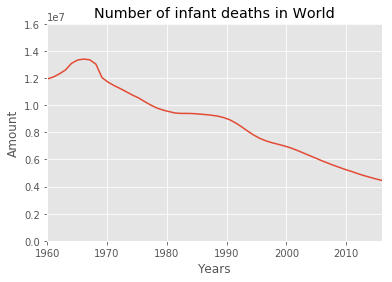

In [12]:
n = np.random.choice(indicators)
co = datamed.iloc[n,0]
ic = datamed.iloc[n,2]
d = datamed.iloc[n, 4:].tolist()

x, y = np.linspace(1960,2016, 2016-1960), d
plt.figure()
plt.title('{} in {}'.format(ic,co))
plt.plot(x,y)
plt.axis([min(x),max(x),0,max(y)+np.std(y)])
plt.xlabel('Years')
plt.ylabel('Amount')
plt.show()

Similarly, instead of getting a full time-series of a data, let's see which years have full data to compare.

In [13]:
vals_y = vals.T
a = []
[a.append(1) if ~pd.isnull(i).any() else a.append(0) for i in vals_y]
years = [i for i, x in enumerate(a) if x == 1]
print(years)

[]


To our bad luck, there is no year with complete data. Let's find the year with most data available.

In [14]:
years = []
k = [years.append(sum(~pd.isnull(i))) for i in vals_y]
print(years)

[626, 357, 358, 386, 405, 515, 433, 440, 457, 491, 810, 549, 537, 543, 577, 725, 608, 586, 613, 617, 1055, 1108, 1045, 1112, 1229, 1298, 1480, 1573, 1415, 1576, 6117, 5460, 5601, 5676, 5799, 8722, 8730, 8608, 8735, 8799, 11538, 8974, 8987, 9086, 9227, 9827, 9782, 9287, 9174, 9265, 10486, 9338, 9633, 8130, 7829, 5426]


In [15]:
topyear = 1960+years.index(max(years))
print('The year with most indicators is... {}!'.format(topyear))

The year with most indicators is... 2000!


The year 2000 has a lot of data but it is not sure that all the countries have all the indicators or if some year with less data has a complete indicator list. Let's focus on a single medical record and see what happens.

In [16]:
mask1 = datamed['Indicator Name'].str.contains('Cause of death, by non-communicable diseases')

ready = datamed[mask1][['Country Code', '2000']]
ready.tail(10)

,Country Code,2000
85632,URY,85.2
85977,UZB,70.0
86322,VUT,NaN
86667,VEN,66.1
87012,VNM,65.7
87357,VIR,NaN
87702,WBG,NaN
88047,YEM,31.2
88392,ZMB,14.9
88737,ZWE,15.7


In [17]:
map_plot = folium.Map(location=[42, 2], zoom_start=2, control_scale=True, prefer_canvas=True)
map_plot.choropleth(geo_path=country_geo, data=ready,
             columns=ready.columns.tolist(),
             key_on='feature.id',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='{}s cause of death, by non-communicable diseases (%)'.format(ready.columns.tolist()[-1]),
             highlight = True)
map_plot

In [18]:
#map_plot.save('plot_data.html')

### 3. Explore certain data

We need to know which are the indicators that we can scrutiny. In order to do that, we can display a list of available indicators:

In [19]:
for i,x in enumerate(sorted(zip(med_codes, med))):
    print('{:2}. {:14}\t{}'.format(i+1, x[0], x[1]))

 1. SH.ANM.CHLD.ZS	Prevalence of anemia among children (% of children under 5)
 2. SH.ANM.NPRG.ZS	Prevalence of anemia among non-pregnant women (% of women ages 15-49)
 3. SH.CON.1524.FE.ZS	Condom use, population ages 15-24, female (% of females ages 15-24)
 4. SH.CON.1524.MA.ZS	Condom use, population ages 15-24, male (% of males ages 15-24)
 5. SH.DTH.COMM.ZS	Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)
 6. SH.DTH.IMRT   	Number of infant deaths
 7. SH.DTH.INJR.ZS	Cause of death, by injury (% of total)
 8. SH.DTH.MORT   	Number of under-five deaths
 9. SH.DTH.NCOM.ZS	Cause of death, by non-communicable diseases (% of total)
10. SH.DTH.NMRT   	Number of neonatal deaths
11. SH.DYN.AIDS.FE.ZS	Women's share of population ages 15+ living with HIV (%)
12. SH.DYN.AIDS.ZS	Prevalence of HIV, total (% of population ages 15-49)
13. SH.DYN.MORT   	Mortality rate, under-5 (per 1,000)
14. SH.DYN.MORT.FE	Mortality rate, under-5, female (per 1,

In [20]:
for i,x in enumerate(datamed['Country Name'].unique().tolist()):
    print('{:3}. {}'.format(i+1,x))

  1. Arab World
  2. Caribbean small states
  3. Central Europe and the Baltics
  4. Early-demographic dividend
  5. East Asia & Pacific
  6. East Asia & Pacific (excluding high income)
  7. East Asia & Pacific (IDA & IBRD countries)
  8. Euro area
  9. Europe & Central Asia
 10. Europe & Central Asia (excluding high income)
 11. Europe & Central Asia (IDA & IBRD countries)
 12. European Union
 13. Fragile and conflict affected situations
 14. Heavily indebted poor countries (HIPC)
 15. High income
 16. Late-demographic dividend
 17. Latin America & Caribbean
 18. Latin America & Caribbean (excluding high income)
 19. Latin America & the Caribbean (IDA & IBRD countries)
 20. Least developed countries: UN classification
 21. Low & middle income
 22. Low income
 23. Lower middle income
 24. Middle East & North Africa
 25. Middle East & North Africa (excluding high income)
 26. Middle East & North Africa (IDA & IBRD countries)
 27. Middle income
 28. North America
 29. OECD members
 30. O

Now we know the names and codes for all health-related indicators. One hypothesis that we might think of is:

 * Is condom usage in males increasing over the years?
 * Is that different from the female attitude?
 * Is it different in developed countries than undeveloped ones?
 * Is there any correlation between the amount of community health workers or nurses and midwives or physicians and the use of condoms?
 
Let's start exploring the questions. The codes that we will need are:
 * Male condom usage: `SH.CON.1524.MA.ZS`
 * Female condom usage: `SH.CON.1524.FE.ZS`
 * Community health workers: `SH.MED.CMHW.P3`
 * Nurses and midwives: `SH.MED.NUMW.P3`
 * Physicians: `SH.MED.PHYS.P3`
 
As most of this work is going to be repetitive to obtain the data from the database, we will create a function to extract the data that we want and then apply it to the variables.

In [21]:
#Function to use all the time:
def dfPrep(db, code):
    #Prepare the data:
    a = db[db['Indicator Code'].str.contains(code)]
    b = a.fillna(0)[41:]
    vals = b.values[:,4:] #Rows = countries, columns = years.

    #Cleaning stuff:
    means, n_count = np.zeros(vals.shape[1]), np.zeros(vals.shape[1])
    for i,x in enumerate(np.transpose(vals)):
        if any(x != 0.0):
            aux = x[x!=0.0]
            means[i] = np.mean(aux)
            n_count[i] = len(aux)
    print('Maximum number of countries that answered: {:.0f}.'.format(n_count.max()))
    #Create a new DataFrame with the interesting things
    ready = pd.DataFrame(data = np.transpose([means, n_count]),
                         columns = ['Means', '#countries'],
                         index = np.arange(1960,2016))
    ready['#countries'] = ready['#countries'].astype(int)
    return ready

Maximum number of countries that answered: 13.
Maximum number of countries that answered: 14.


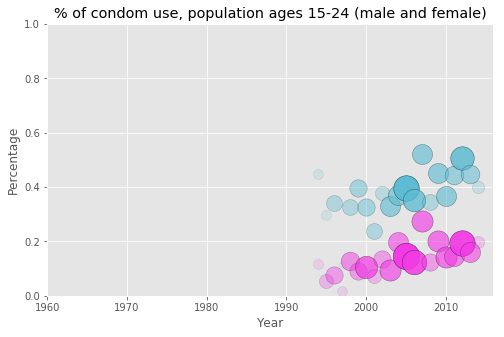

In [22]:
#Start working
male = dfPrep(datamed, 'SH.CON.1524.MA.ZS')
female = dfPrep(datamed, 'SH.CON.1524.FE.ZS')

#Plot it:
male_ready = male[male['Means']>0.0]
fema_ready = female[female['Means']>0.0]

plt.figure(figsize = (8,5))
for i in male_ready.index:
    plt.scatter(i,male_ready['Means'][i]/100, c = '#5DBCD2', 
                s = male_ready['#countries'][i]*50, 
                alpha = male_ready['#countries'][i]/male_ready['#countries'].max(),
                edgecolors = '#1f464f')
for i in fema_ready.index:
    plt.scatter(i,fema_ready['Means'][i]/100, c = '#f23ae5', 
                s = fema_ready['#countries'][i]*50, 
                alpha = fema_ready['#countries'][i]/fema_ready['#countries'].max(),
                edgecolors = '#4f1f4f')
plt.xlim([1960, 2016])
plt.ylim([0,1])
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.title('% of {} (male and female)'.format(
    datamed[datamed['Indicator Code'] == 'SH.CON.1524.MA.ZS'].values[0,2][:33].lower()))
plt.show()

As we can see, women tend to avoid using the condom and the recorded data is scarce. The size and transparency of the bubbles indicate the amount of countries that gave data to the world data bank. As we can see, they are not a lot given that the maximum number of countries is around 14. If we want to see, for example, which countries are the ones that make the peak in the male condom usage, we can use the following snippet.

In [23]:
topyear = str(male_ready.index[male_ready['Means'] == male_ready['Means'].max()][0])
a = datamed[datamed['Indicator Code'].str.contains('SH.CON.1524.MA.ZS')][41:]
b = pd.DataFrame(data = np.transpose([a['Country Name'], a[topyear]]), columns = ['Country', topyear])
b[b[topyear]>0]

,Country,2007
44,"Congo, Dem. Rep.",20.3
56,Dominican Republic,58
111,Liberia,18.6
136,Namibia,78
180,St. Kitts and Nevis,73.7
186,Swaziland,66
203,Ukraine,64.3
215,Zambia,38.8


Let's see now the data about the health workers.

In [24]:
cmhw = dfPrep(datamed, 'SH.MED.CMHW.P3')
numw = dfPrep(datamed, 'SH.MED.NUMW.P3')
phys = dfPrep(datamed, 'SH.MED.PHYS.P3')

Maximum number of countries that answered: 42.
Maximum number of countries that answered: 150.
Maximum number of countries that answered: 0.


Surprise! There is no data about the amount of physiscians that are in the different countries. Therefore we cannot do anything with that variable.

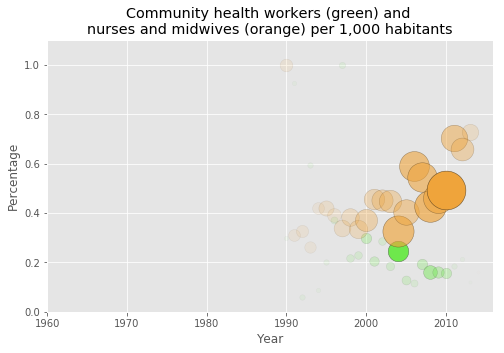

In [25]:
#Plot it:
male_ready = cmhw[cmhw['Means']>0.0]
fema_ready = numw[numw['Means']>0.0]

plt.figure(figsize = (8,5))
for i in male_ready.index:
    plt.scatter(i,male_ready['Means'][i]/male_ready['Means'].max(), c = '#6ee84c', 
                s = male_ready['#countries'][i]*10, 
                alpha = male_ready['#countries'][i]/male_ready['#countries'].max(),
                edgecolors = '#5b7055')
for i in fema_ready.index:
    plt.scatter(i,fema_ready['Means'][i]/fema_ready['Means'].max(), c = '#efa43b', 
                s = fema_ready['#countries'][i]*10, 
                alpha = fema_ready['#countries'][i]/fema_ready['#countries'].max(),
                edgecolors = '#60451f')
plt.xlim([1960, 2016])
plt.ylim([0,1.1])
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.title('{} (green) and \n{} (orange) per 1,000 habitants'.format(
    datamed[datamed['Indicator Code'] == 'SH.MED.CMHW.P3'].values[0,2][:24], 
    datamed[datamed['Indicator Code'] == 'SH.MED.NUMW.P3'].values[0,2][:19].lower()))
plt.show()

Given that the number of data for the condom usage is not very representative it is useless to try to find any relation. However, by pure chance, we can see a very marked effect in the deaths of infants in Haiti: the 2010's earthquake. This is a clear example of a reason of which we can't just get rid of the outliers without thinking first.

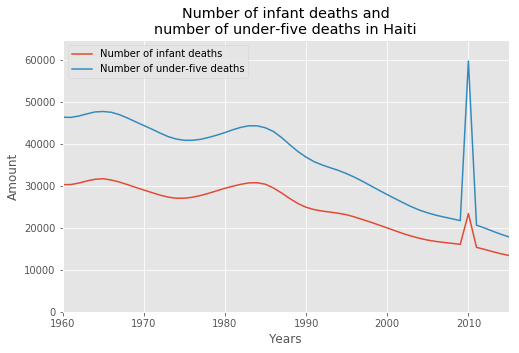

In [26]:
co = 'Haiti'
mask1 = datamed['Country Name'] == co
mask2 = datamed['Indicator Name'].str.contains('death')
mask3 = datamed['1960']>0.0
info = datamed[mask1 & mask2 & mask3]

ic = info['Indicator Name'].tolist()
d = info.values[:,4:]

x, y = np.arange(1960,2016), d
plt.figure(figsize = (8,5))
plt.title('{} and\n{} in {}'.format(ic[0], ic[1].lower(),co))
for i in y:
    plt.plot(x,i)
plt.xlim([min(x), max(x)])
plt.ylim([0, y.max()+np.std(y)/2])
plt.xlabel('Years')
plt.ylabel('Amount')
plt.legend(ic)
#plt.savefig('haiti_eq_outlier.svg', format = 'svg')
plt.show()

And this is all for now! This was an overview of the capacity of **`Pandas`** in managing the data and databases.